# SAN BENIGNO- ORCO RIVER BASIN

13/10/2021 - Marco Mazzolini - ADO

In this notebook results of different feature selections are compared for the San Benigno Basin (of which we have around 18 years of data)

Input data is clipped from ERA5 metereological reanalysis quantile mapped and downscaled.

Monthly averages (for the previous year) of pecipitation, temperature and potential evapotranspiration are selected as input.

The settings are the following:

    A) 180 features are selected with PCA, the same numeriosity as setting C) ;

    B) 36 features are selectedwith PCA, the same numeriosity as setting D) ;
        
    C) metereological inputs spatial statistics are used as input: mean, the 5th, 25th, 75th and 95th quantiles are selected.
        
    D) metereological inputs are spatially averaged.




In [3]:
from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt

import os

import pdb
import seaborn as sns

In [7]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'

daily_input = pd.read_csv(path+'SAN_BENIGNO_ORCO_2002_2019.csv', index_col=0, parse_dates=True)

daily_input_TPE = spatial_avg_daily_input(daily_input)

daily_input_stat = spatial_stats_daily_input(daily_input)

import sys, importlib
importlib.reload(sys.modules['test'])


In [8]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2, 2, 10)
epsilon_range=np.logspace(-6, -2, 5)
#n_range = [17, 50, 200]
components_range = [5*3*12]
#do not enlarge t_range for now

t_range=[12]

#define the temporal unit
t_unit=15
n_splits=5
test_size=365

# A) PCA+SVR

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits

C=1.6681005372000592
eps=2.1544346900318823e-05
n=180


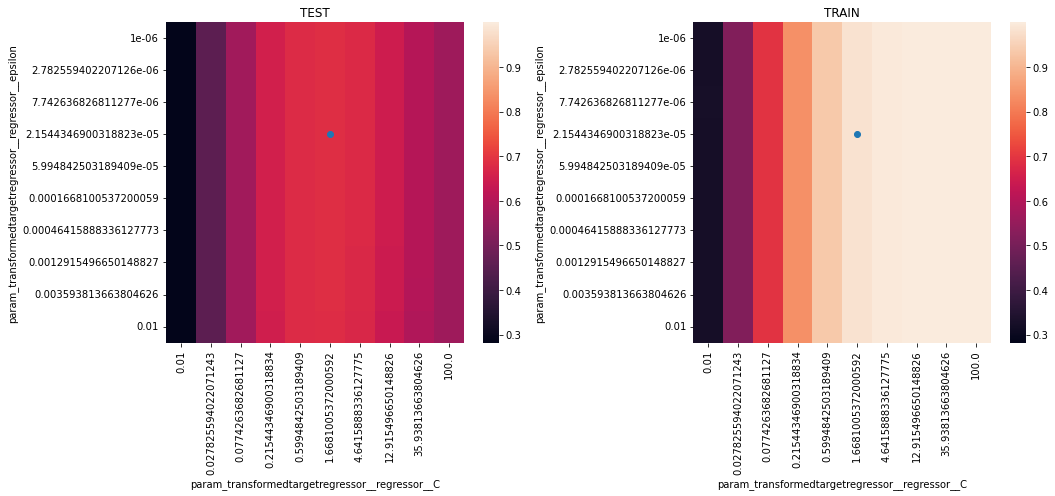

In [10]:
C,eps,n=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')
print(f'n={n}')

C=0.21544346900318834
epsilon=0.003593813663804626
n=180


### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [11]:
radius_for_ensemble = 1
predictions = nested_CV_PCA_SVR_predict(daily_input, C, eps, n, 12,t_unit, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

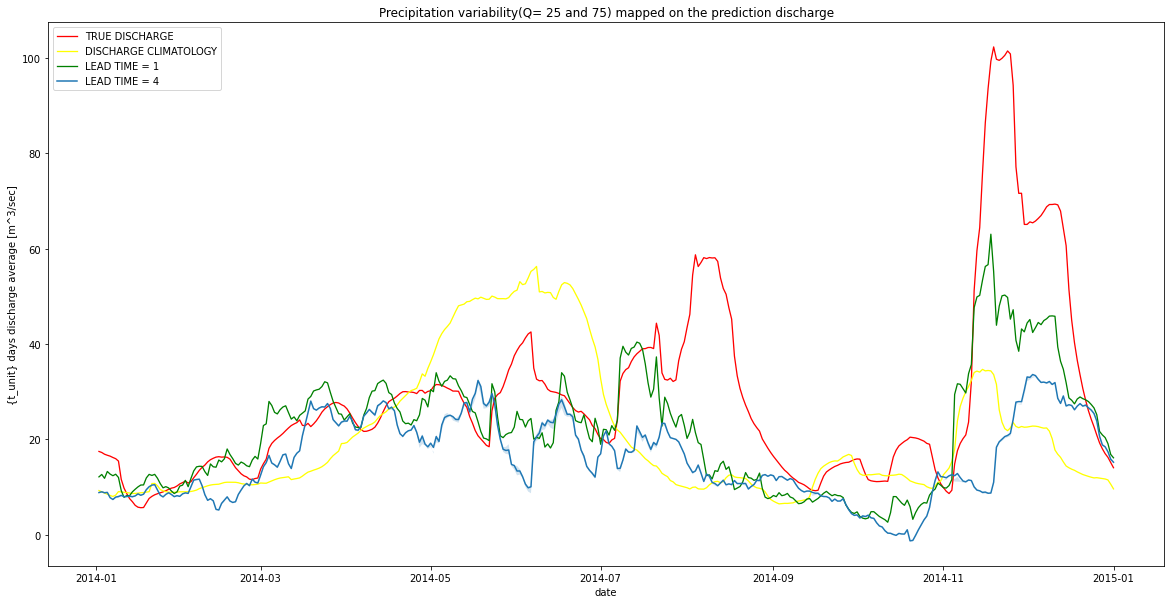

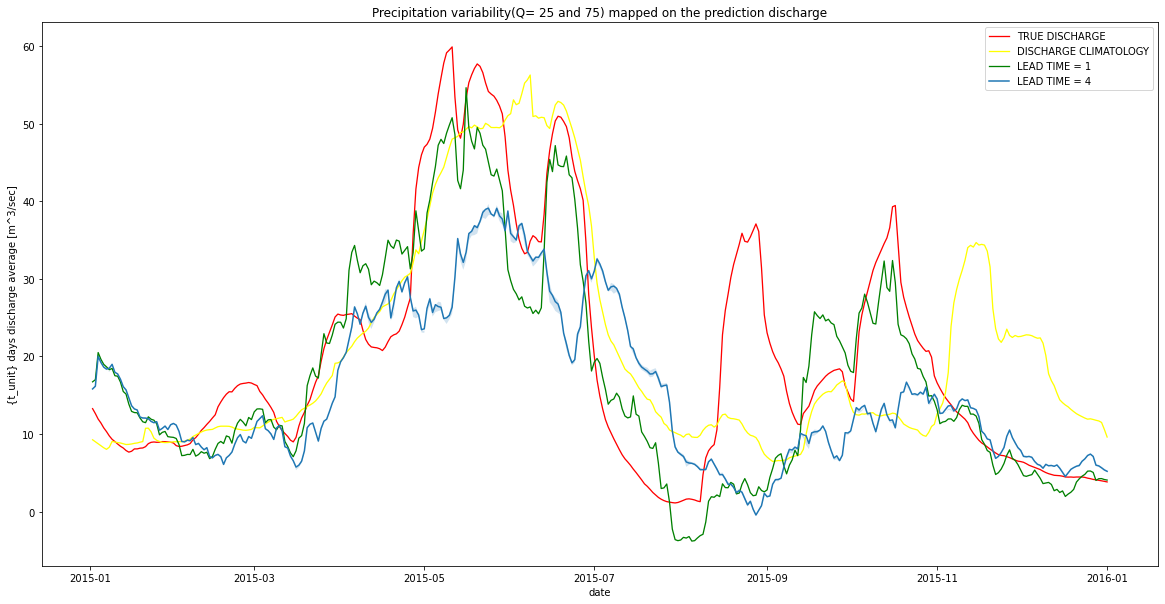

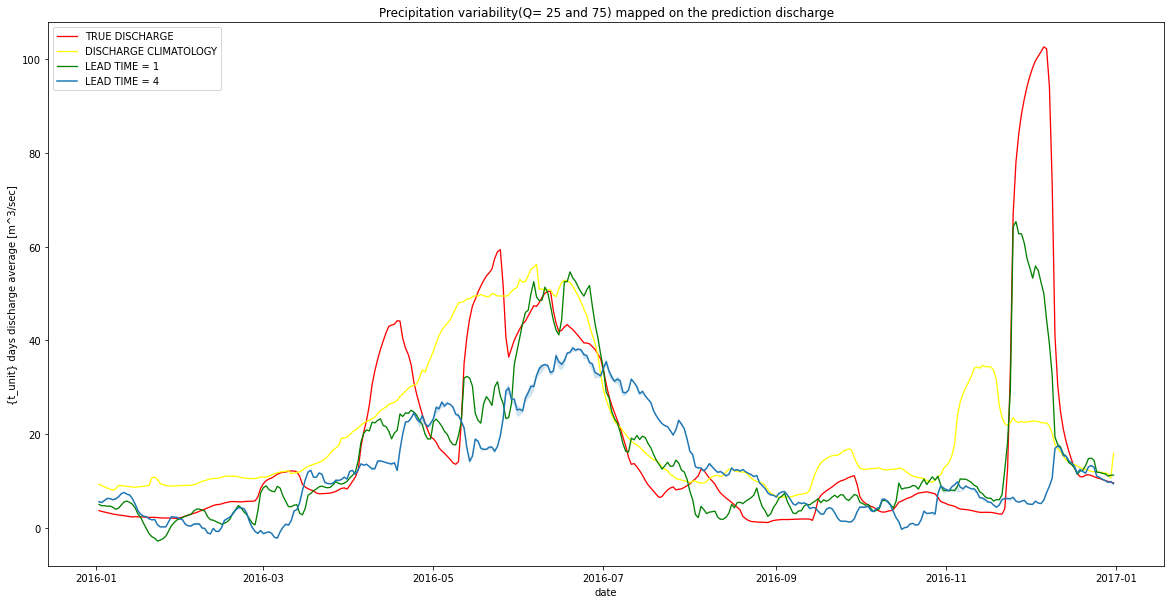

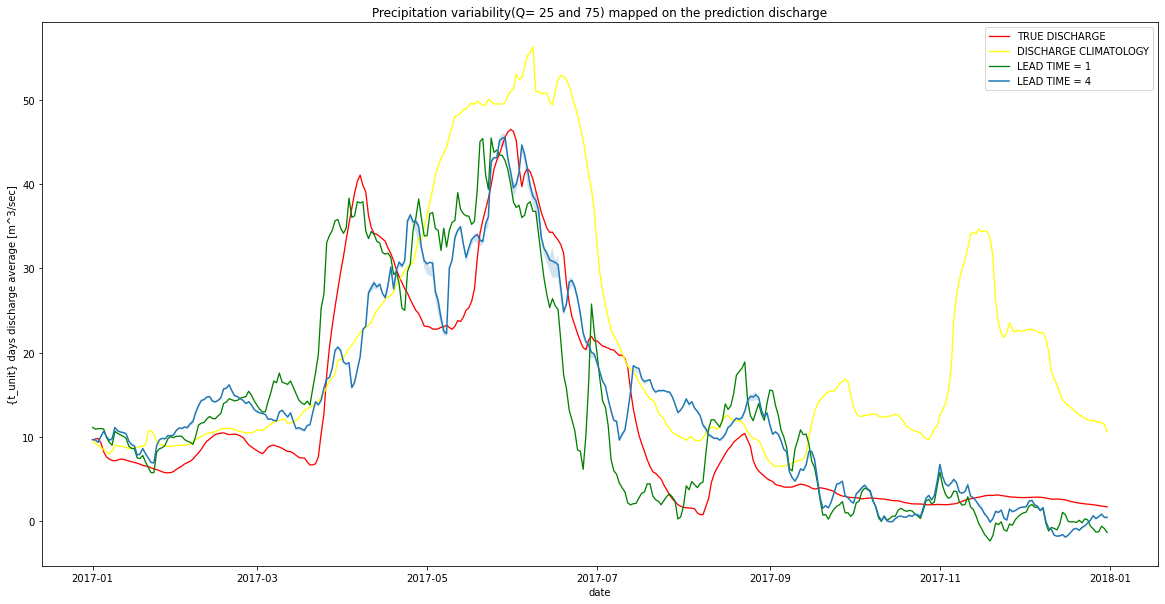

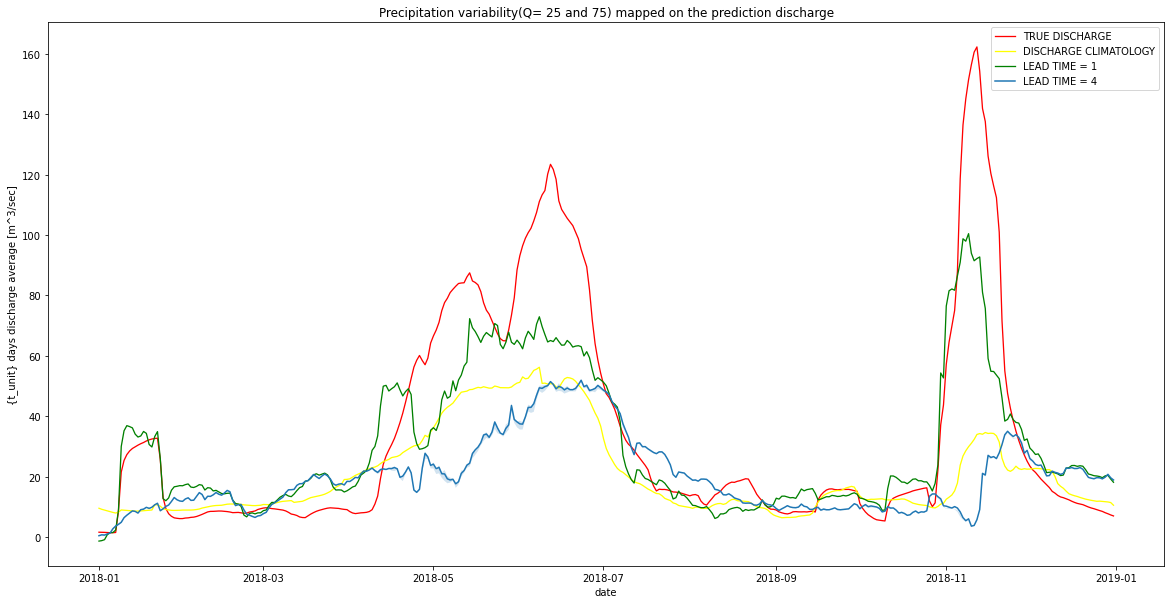

In [12]:
plot_prediction(predictions,t_unit)

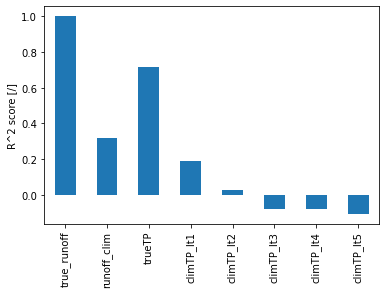

In [13]:
r2_PCA180 = evaluate_prediction(predictions)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [14]:
predictions_for_clim = classic_CV_PCA_SVR_predict(daily_input, C, eps, n, 12,t_unit, n_splits)

In [15]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


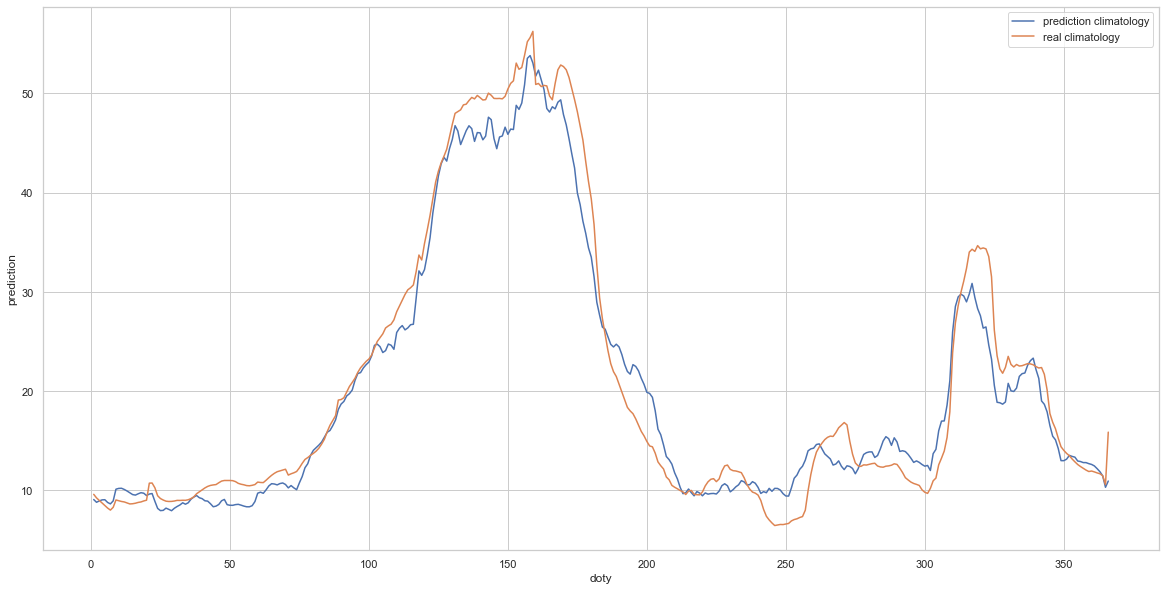

In [16]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [17]:
a=compute_anomalies(climatologies, predictions)


In [18]:
a['split']=predictions.split

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

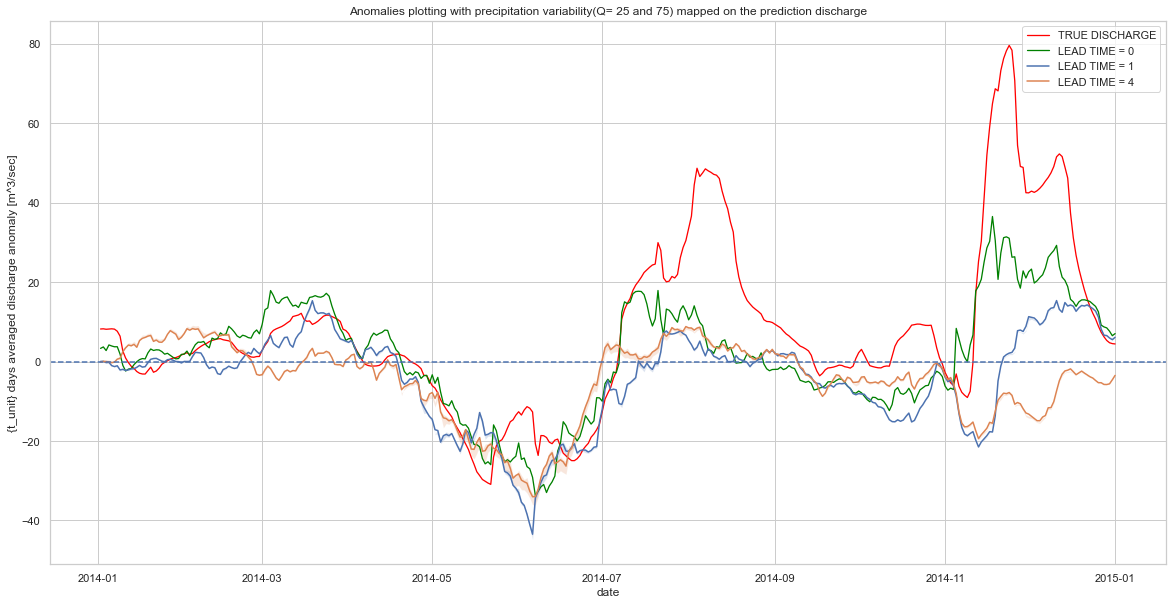

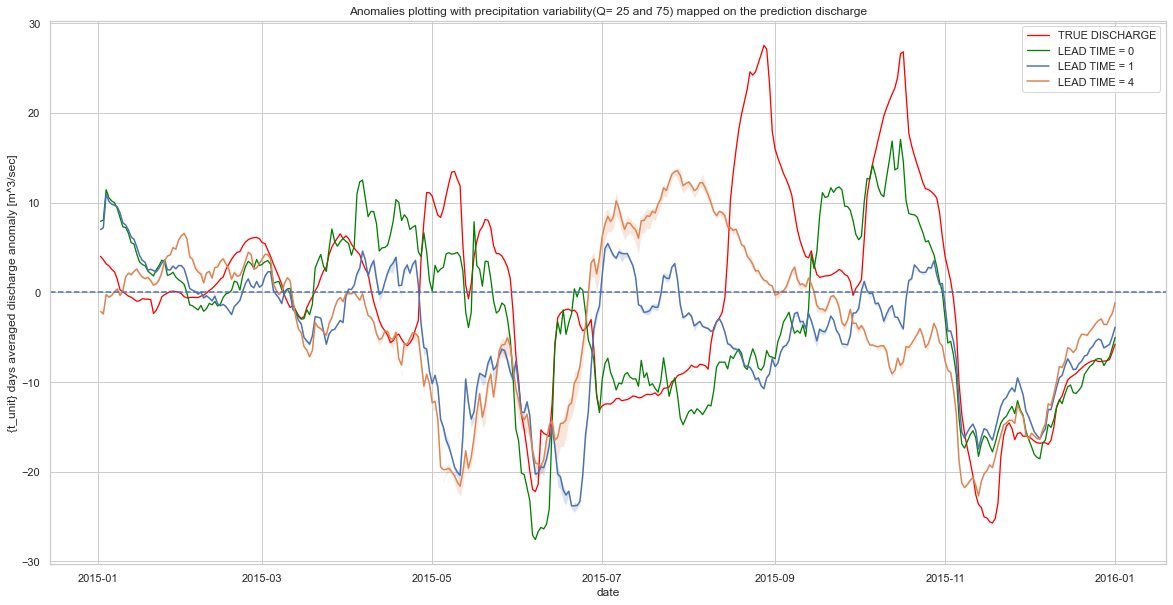

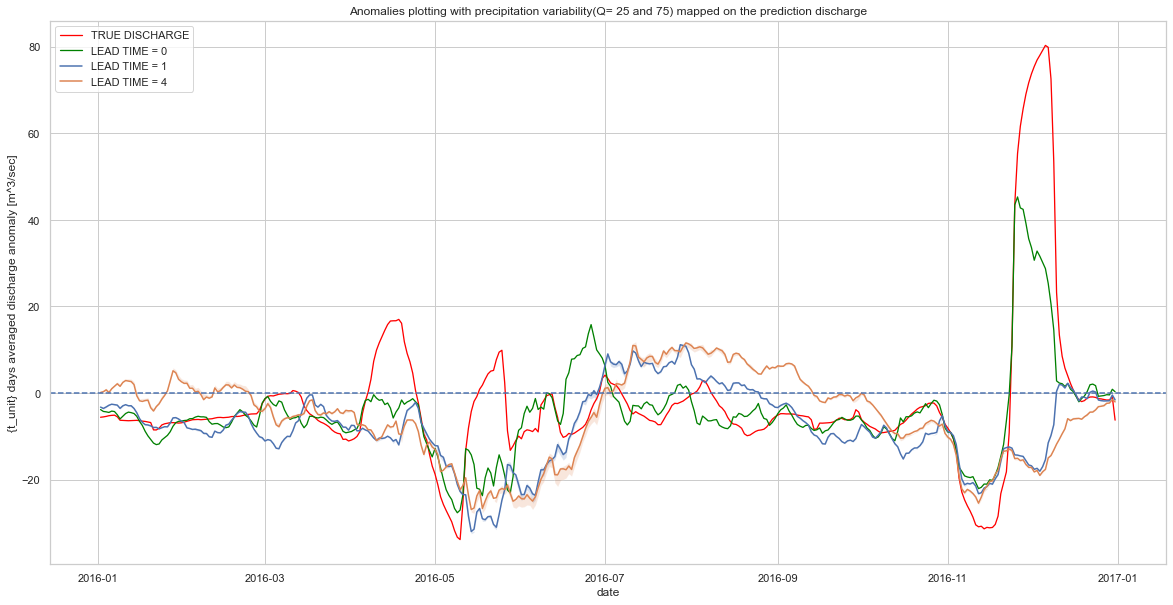

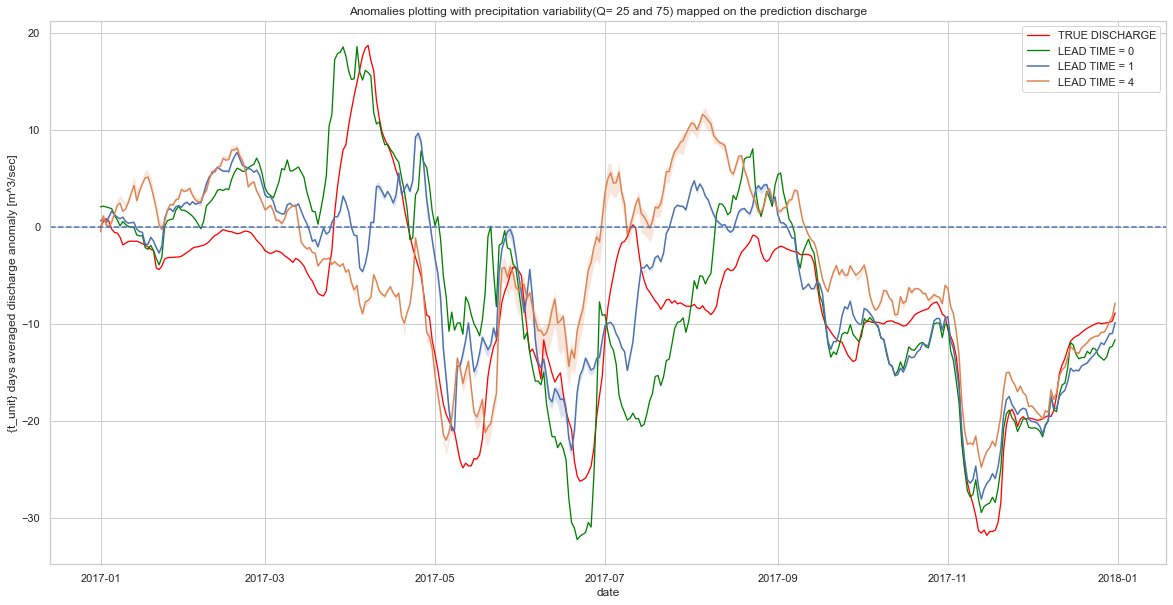

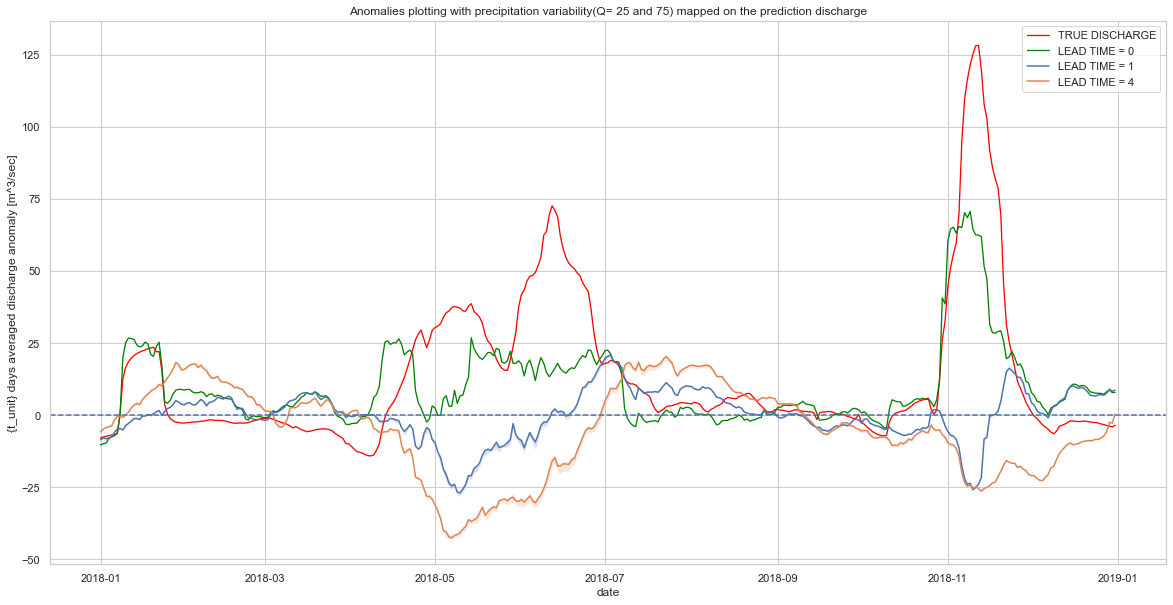

In [19]:
plot_anomalies(a,t_unit)

## B) PCA+SVR 

### TRAIN A PCA+SVR MODEL 

In [14]:
components_range2=[12*3]

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits

C=0.21544346900318834
epsilon=0.00046415888336127773
n=36


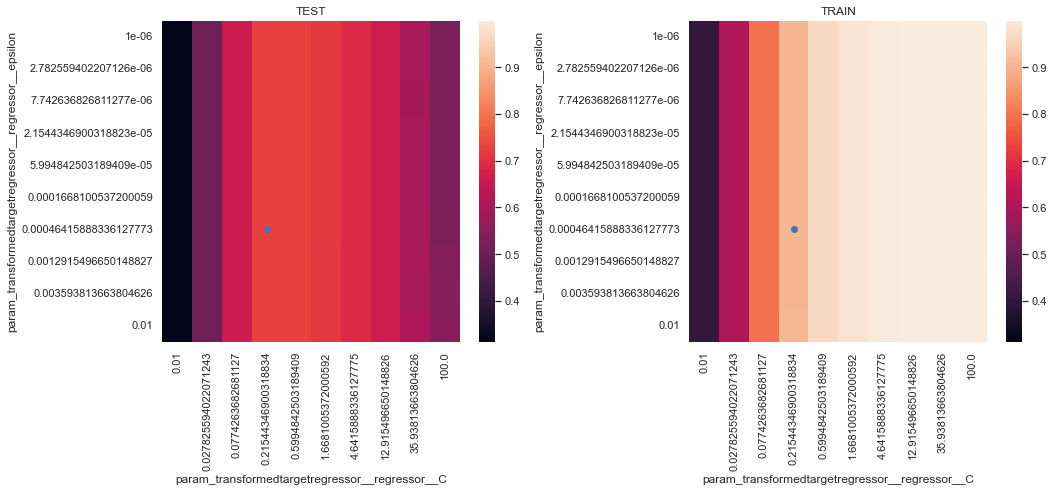

In [15]:
components_range2=[12*3]
C2,eps2,n2=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range2, t_range,n_splits,test_size)
print(f'C={C2}')
print(f'epsilon={eps2}')
print(f'n={n2}')

C2  =0.5994842503189409
eps2=10e-06
n2  =36

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [16]:
radius_for_ensemble = 1
predictions2 = nested_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

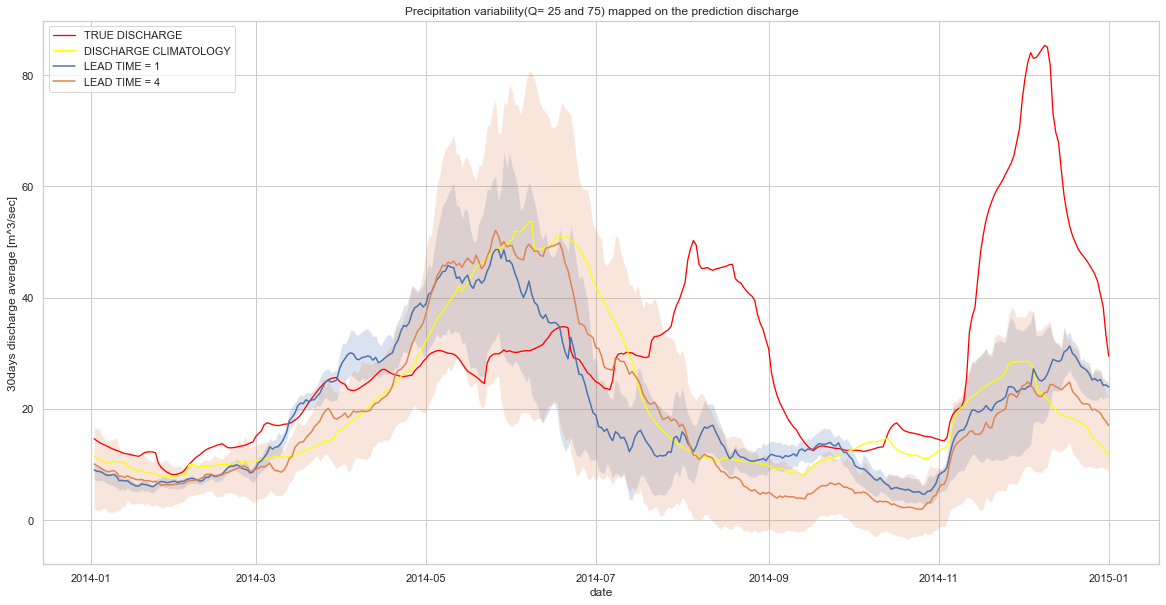

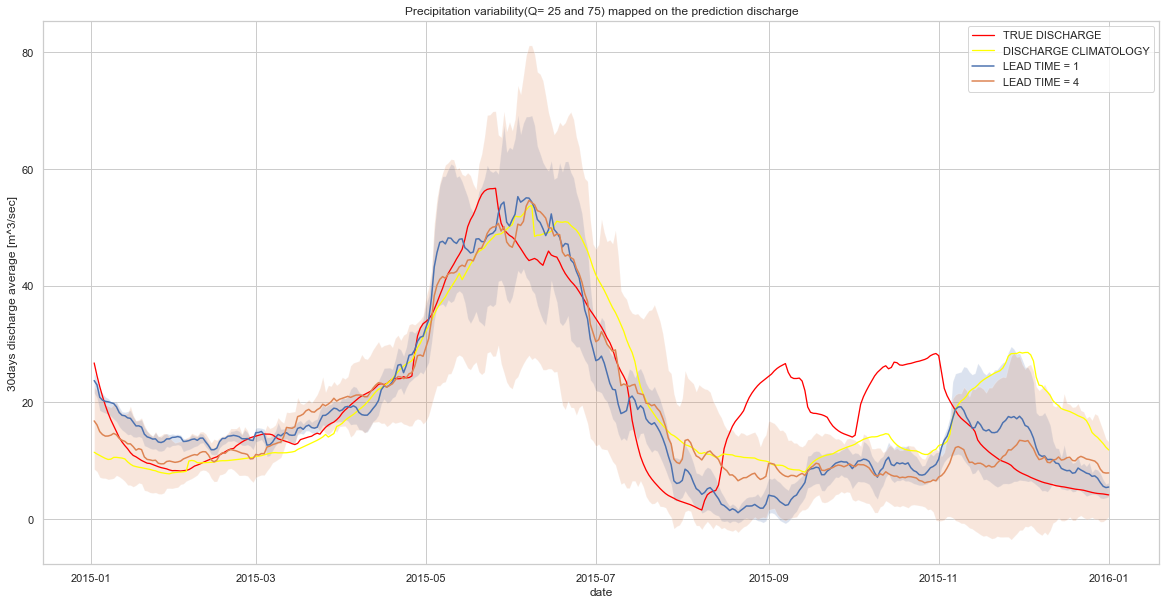

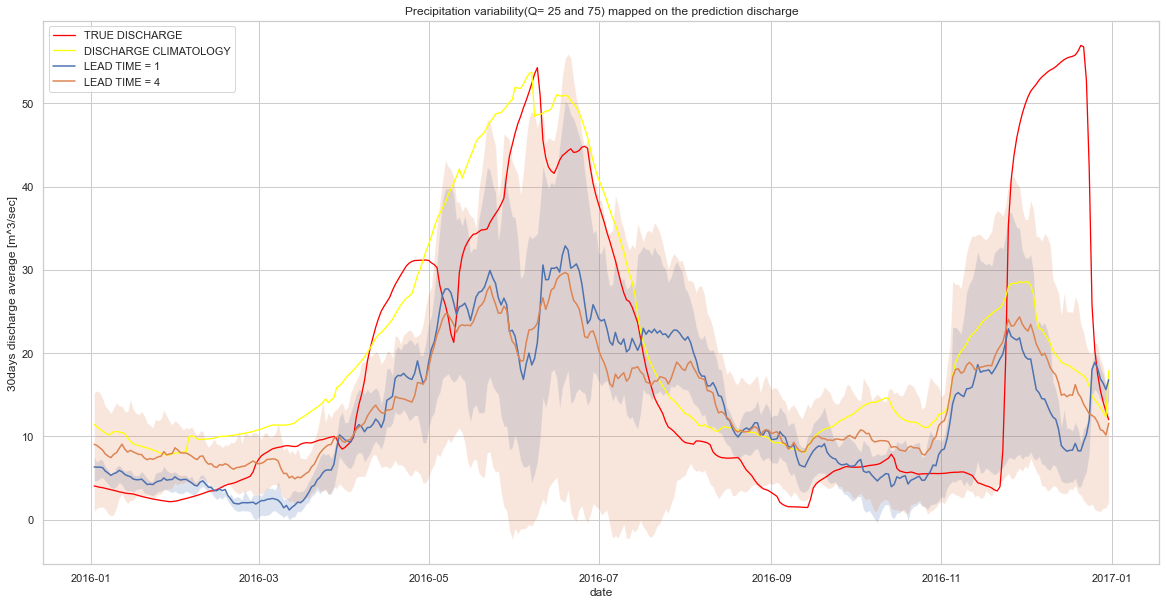

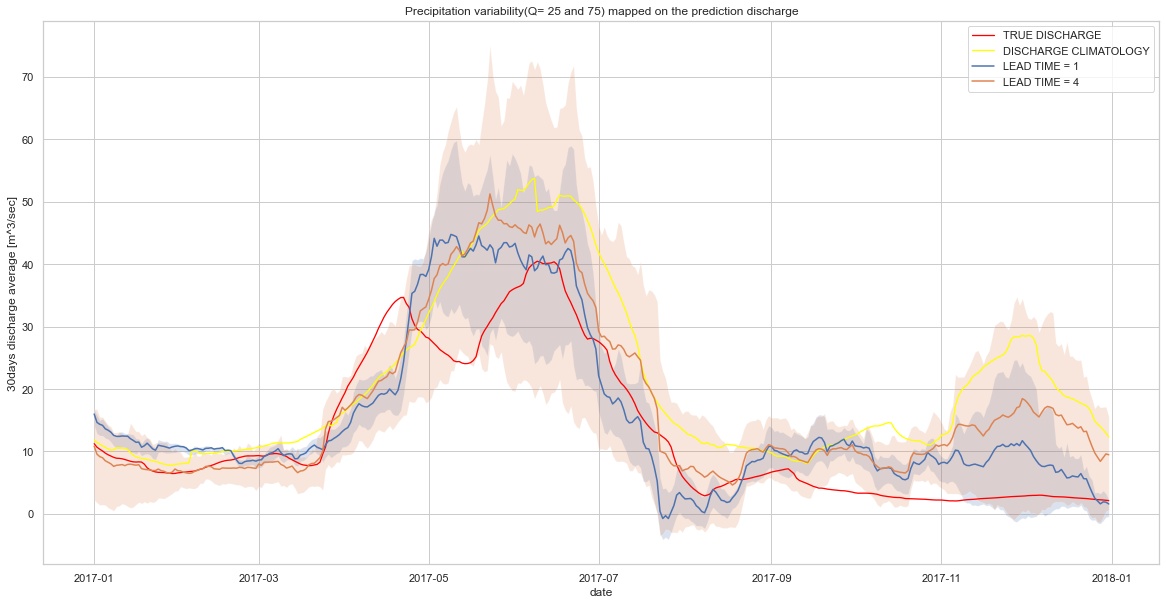

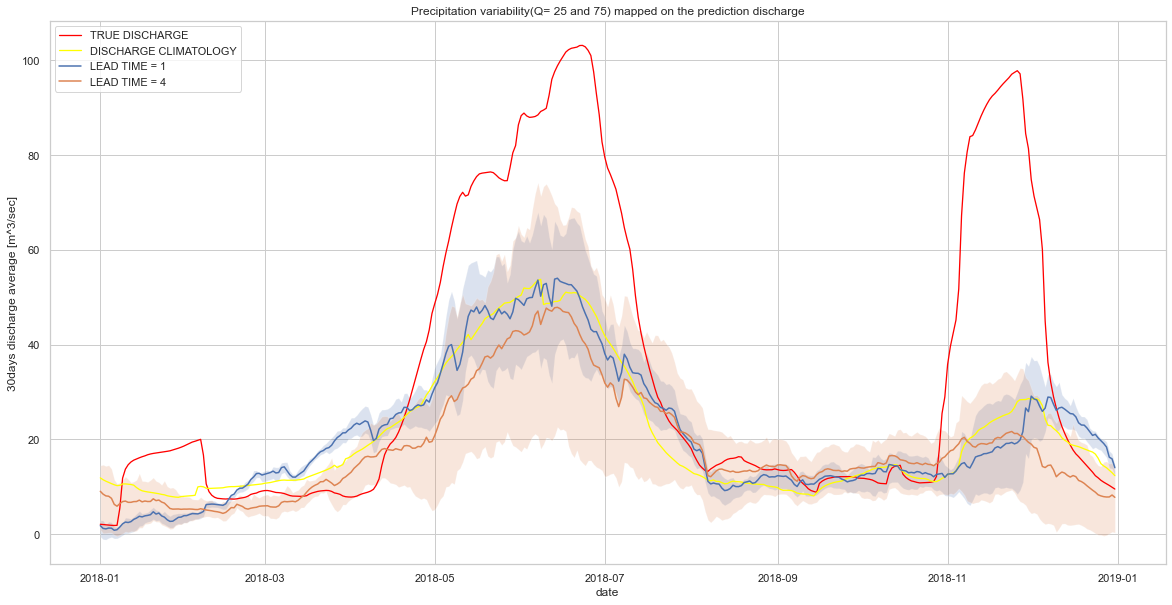

In [17]:
plot_prediction(predictions2)

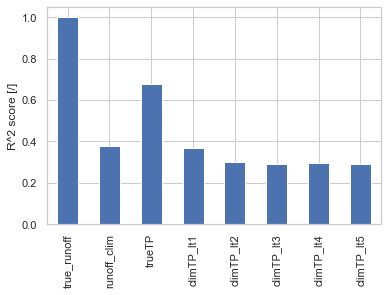

In [18]:
r2_PCA36 = evaluate_prediction(predictions2)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [19]:
predictions_for_clim2 = classic_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12, n_splits)

In [20]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


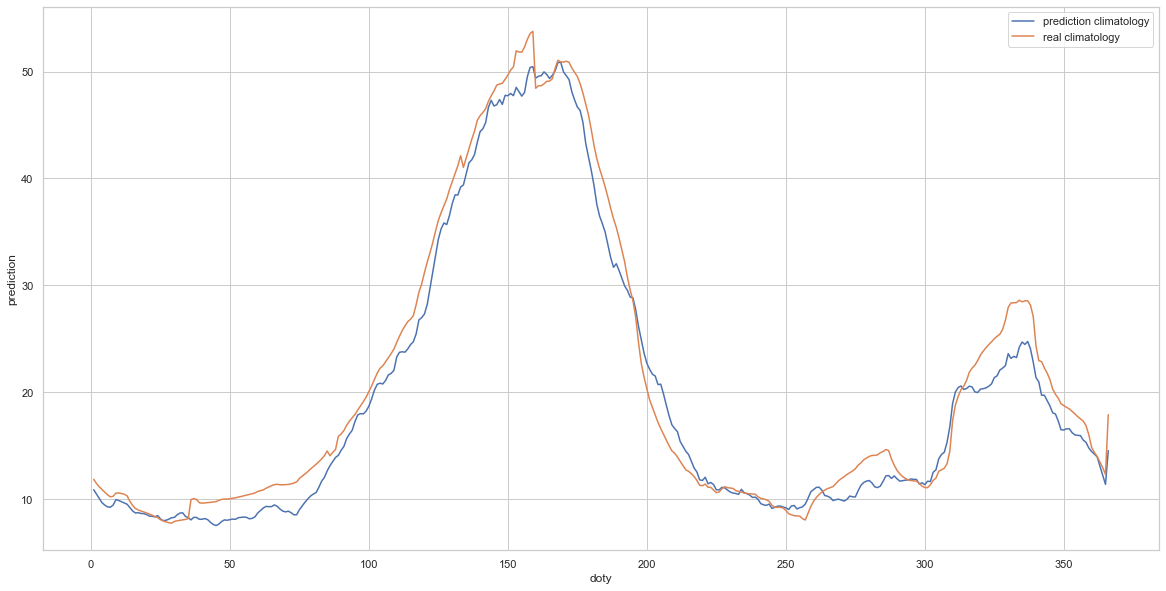

In [21]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

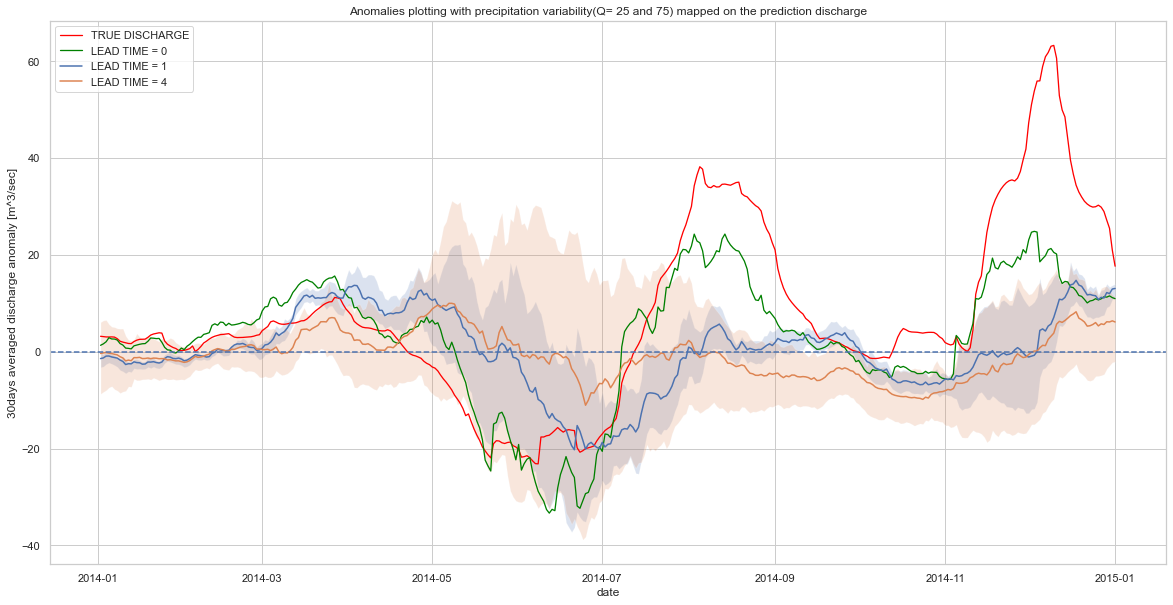

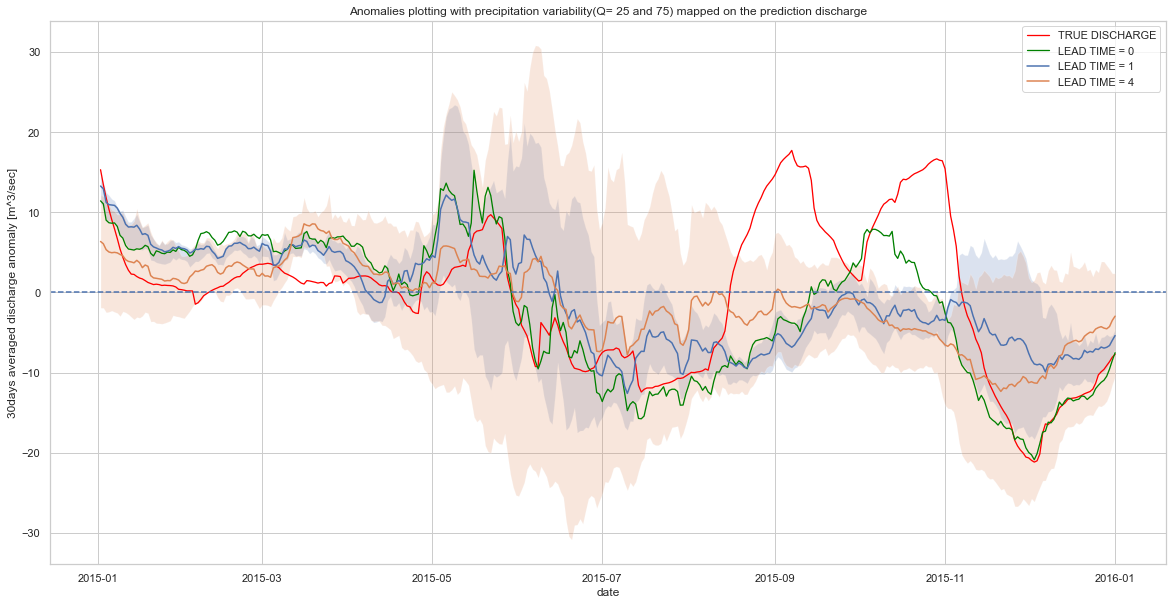

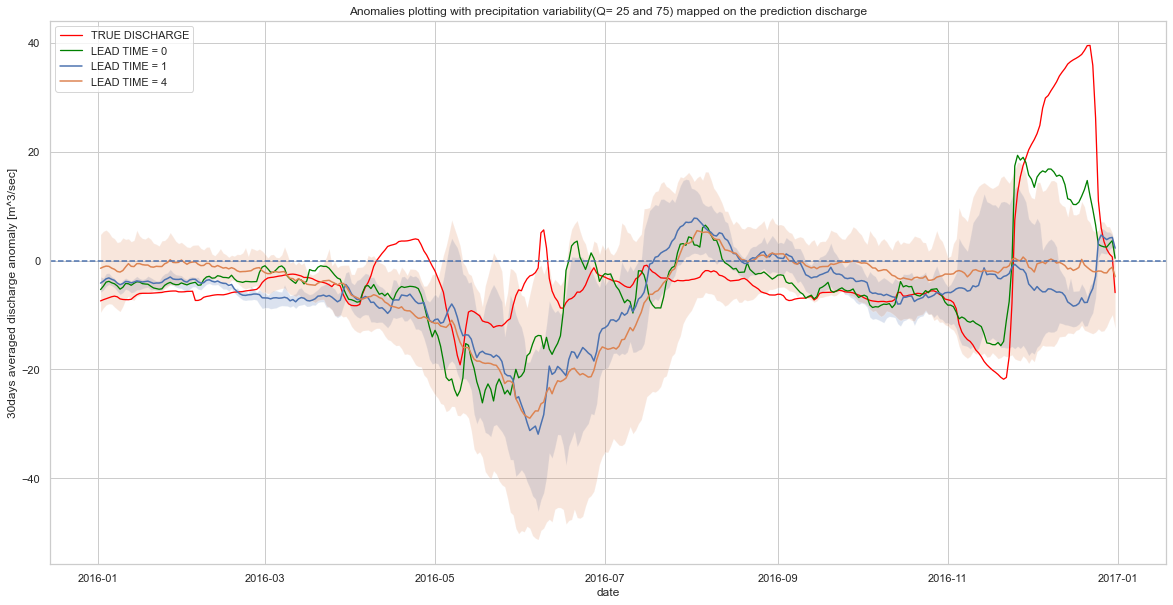

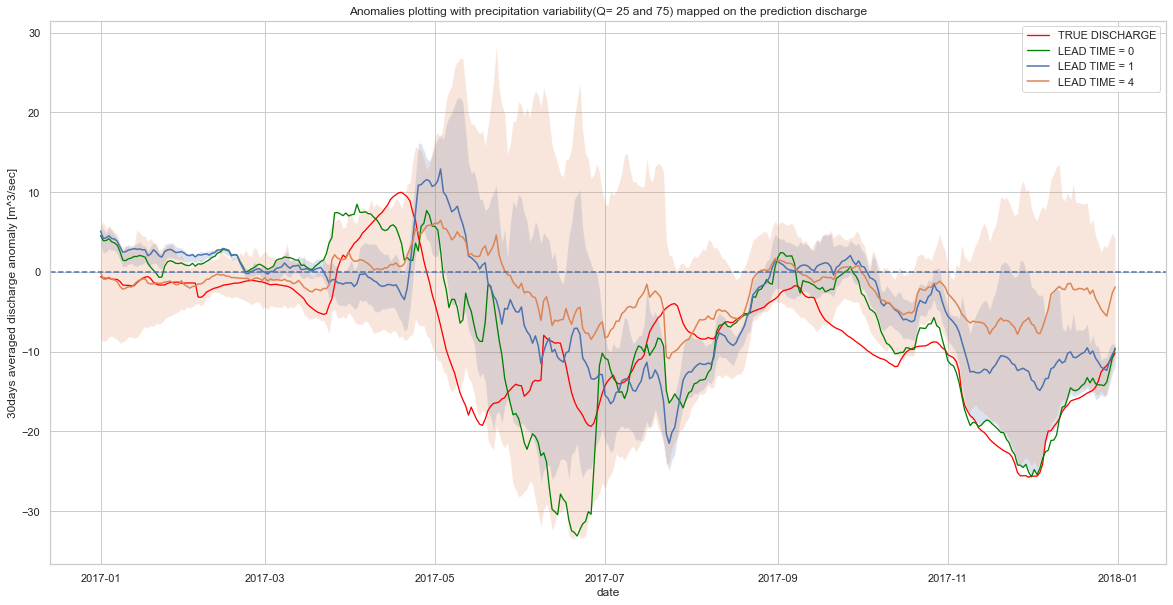

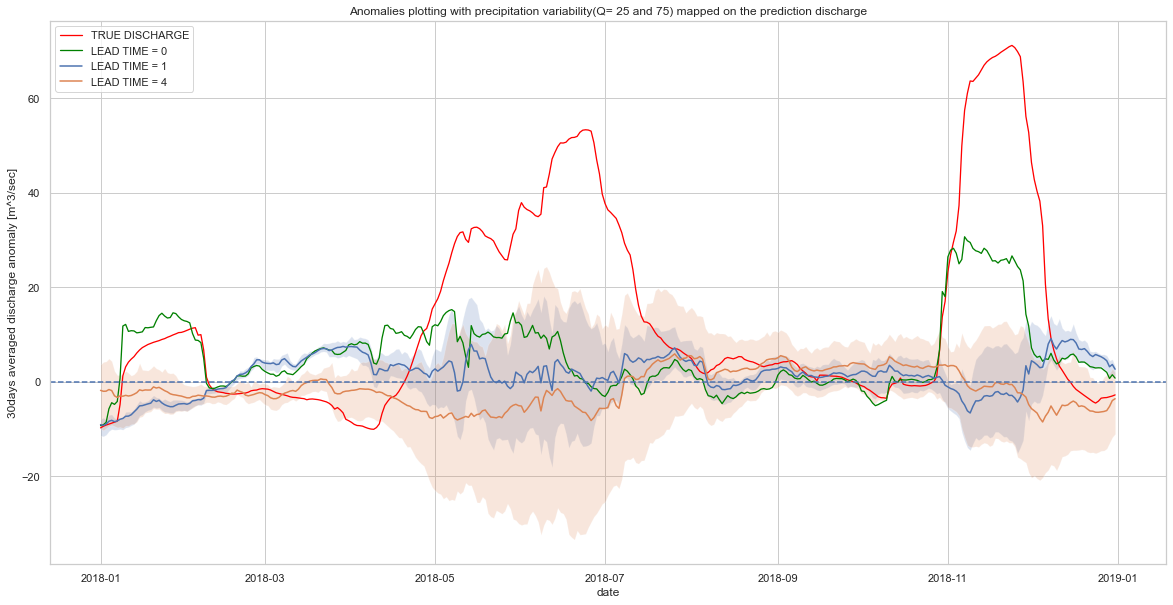

In [24]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2)

# C) SVR 
## WITH SPATIAL STATISTICS AS INPUT

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits

C3=0.5994842503189409
eps3=0.01


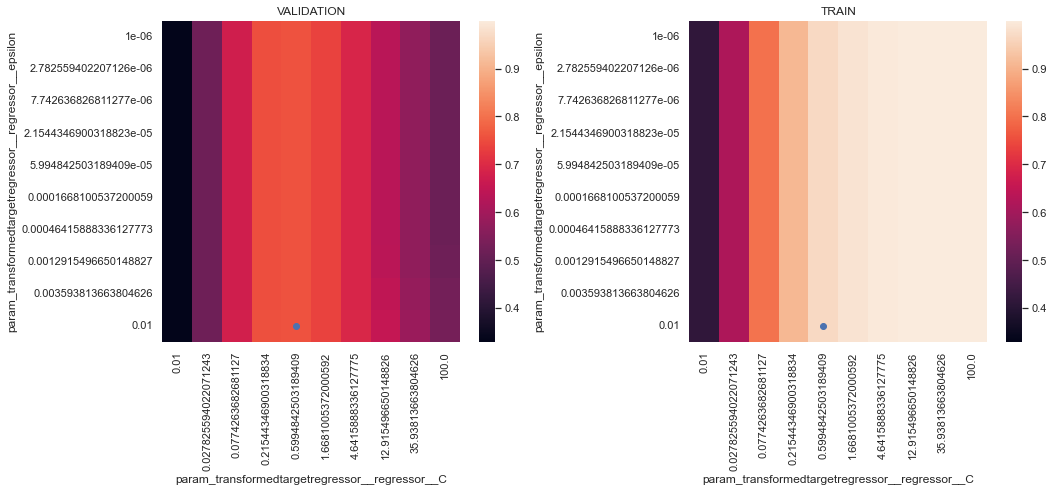

In [25]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,n_splits,test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [26]:
radius_for_ensemble = 1
predictions3 = nested_CV_SVR_predict(daily_input_stat, C3, eps3, 12, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

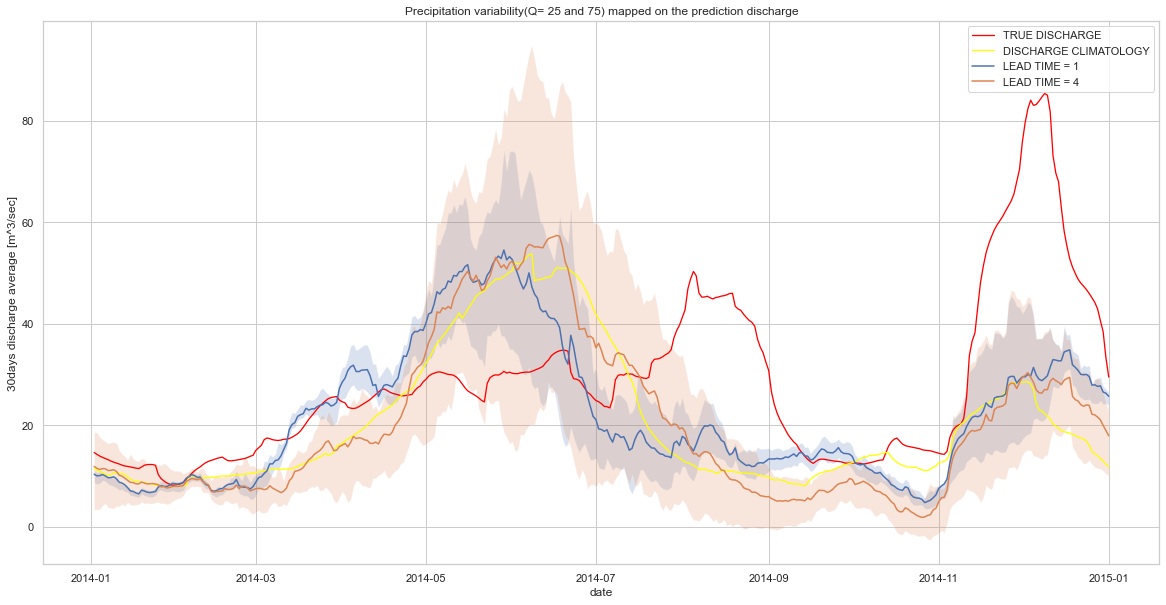

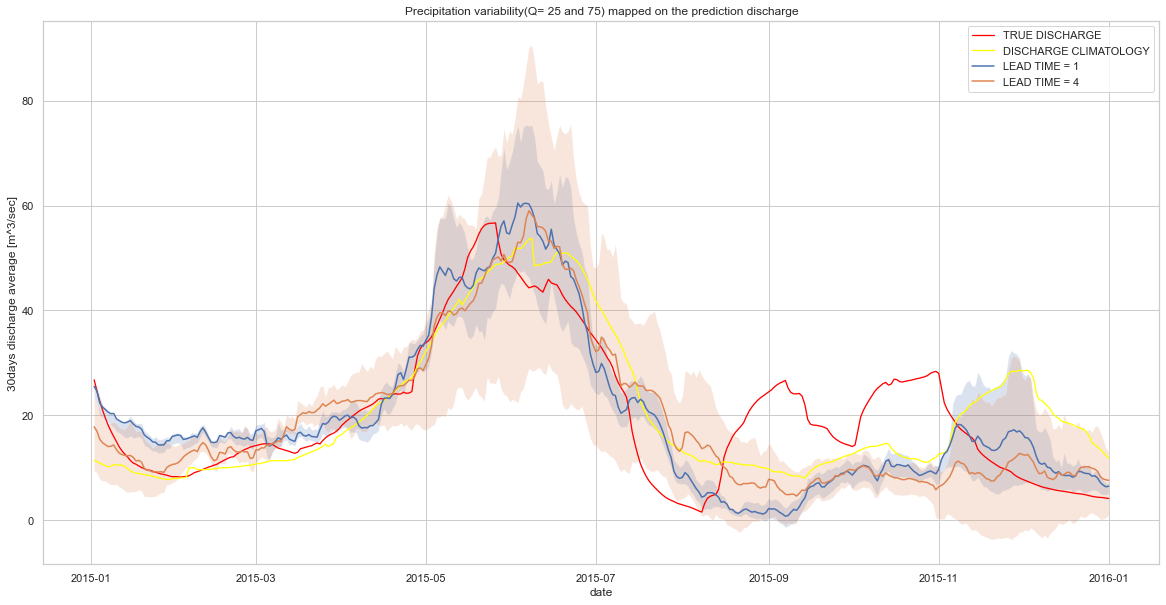

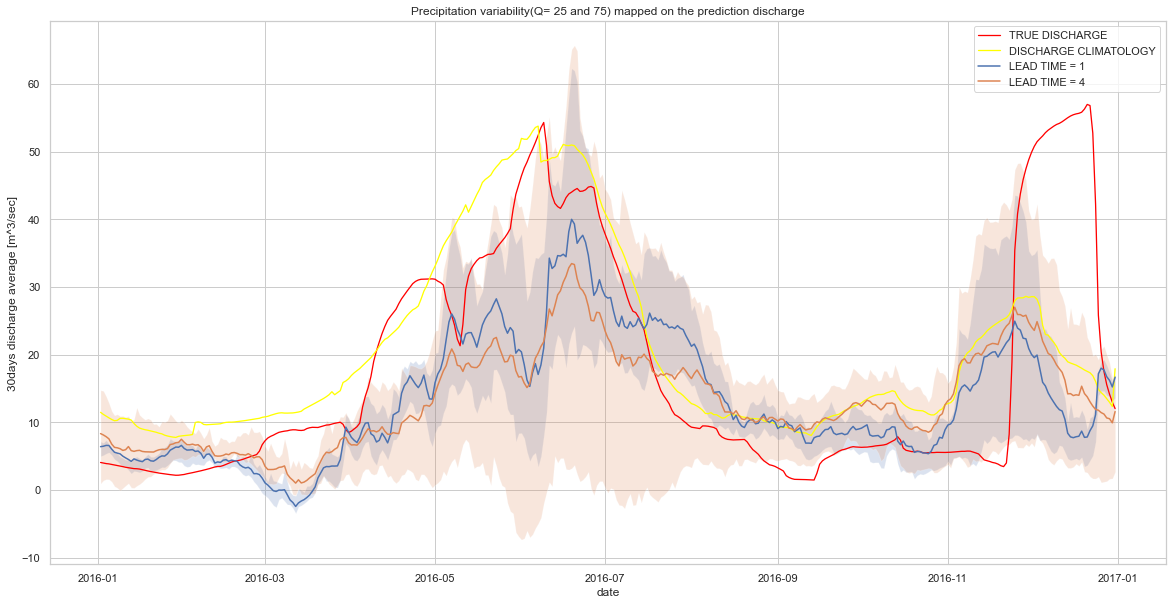

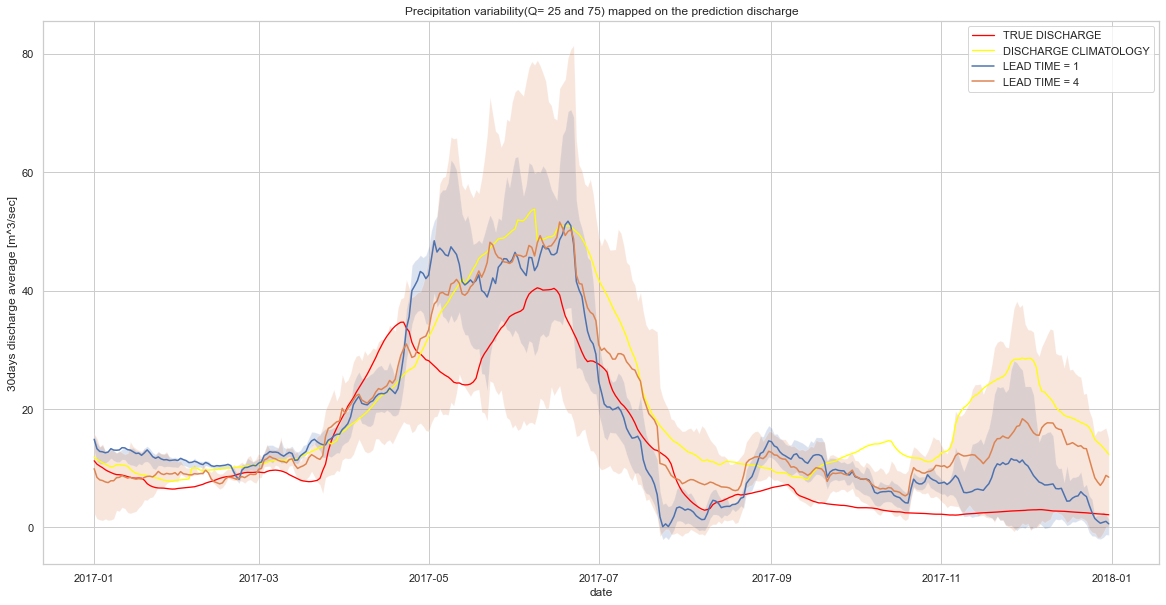

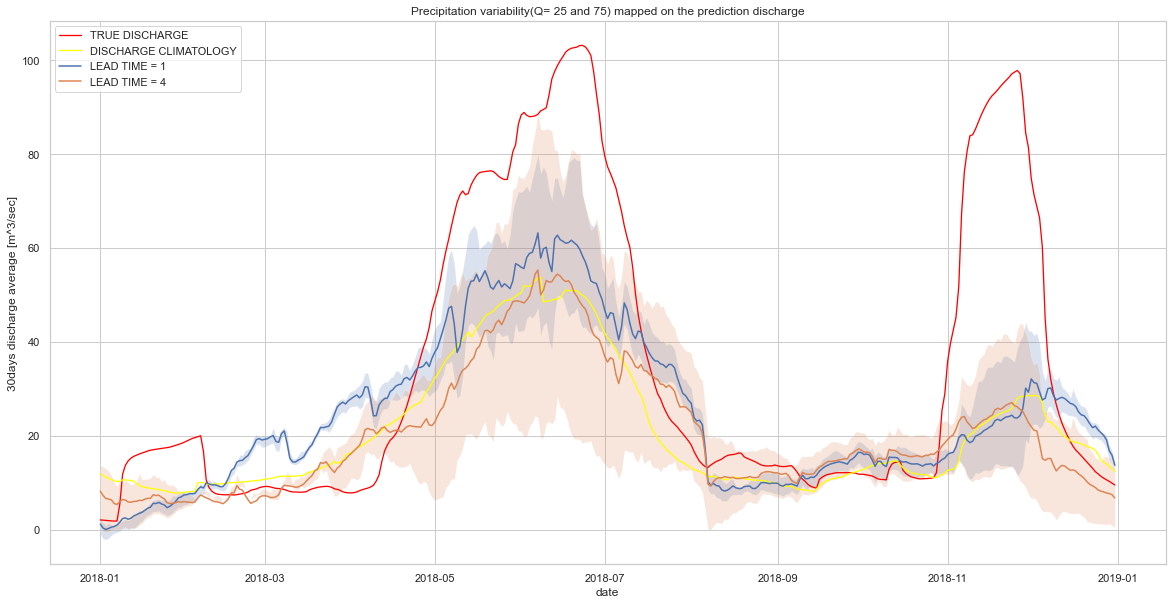

In [27]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3)

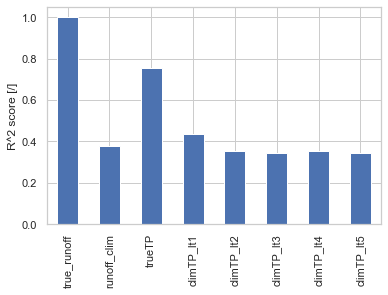

In [28]:
r2_STATS= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [29]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat, C3, eps3, 12, n_splits)

In [30]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


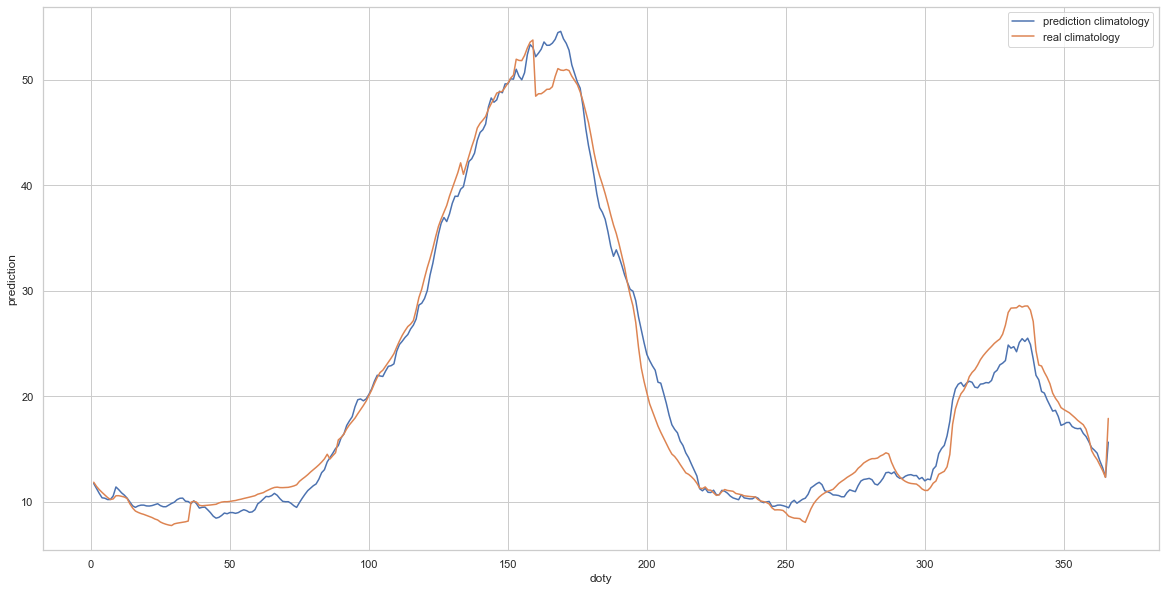

In [31]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

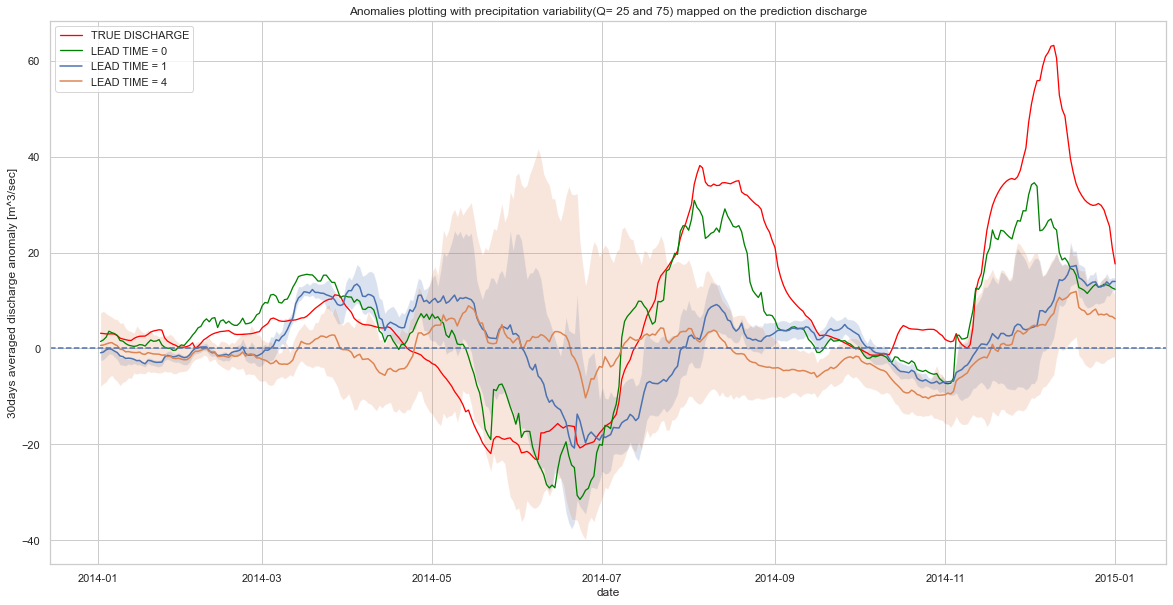

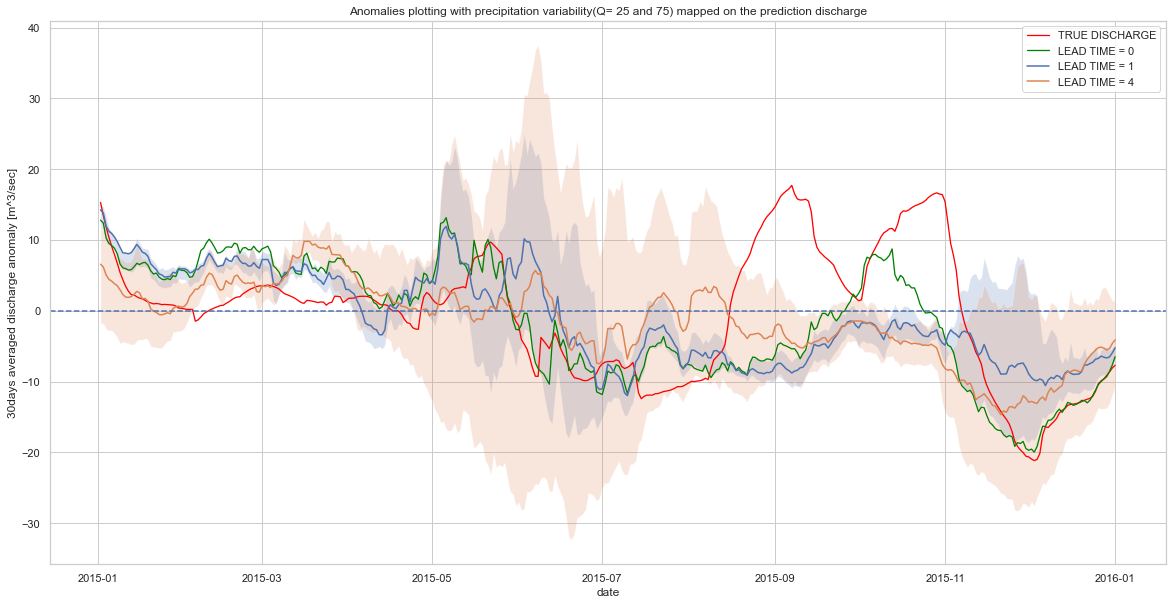

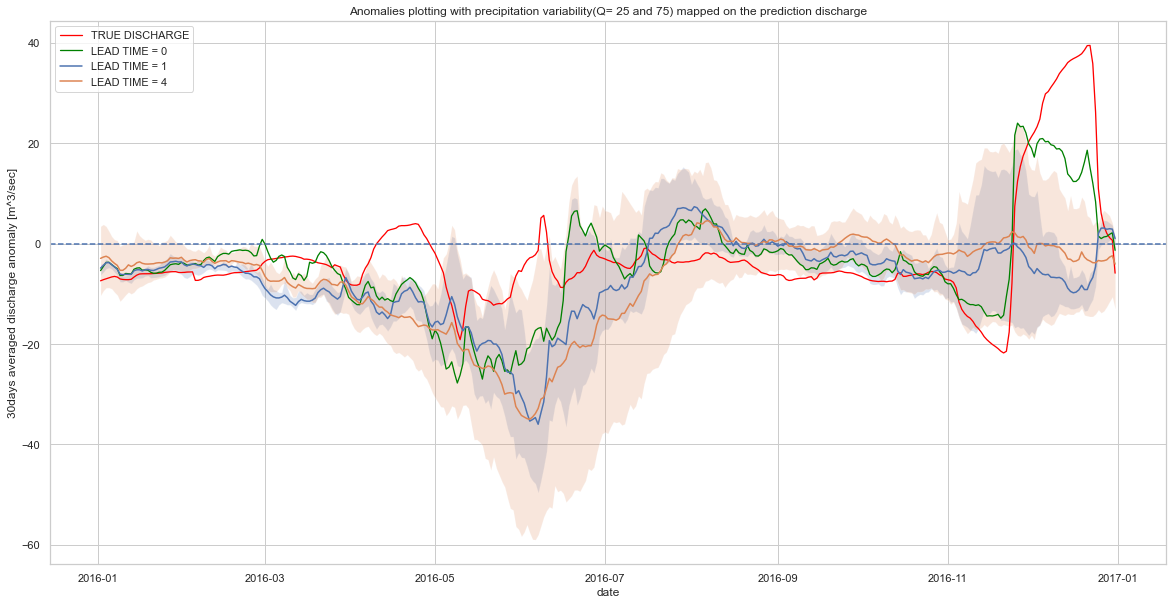

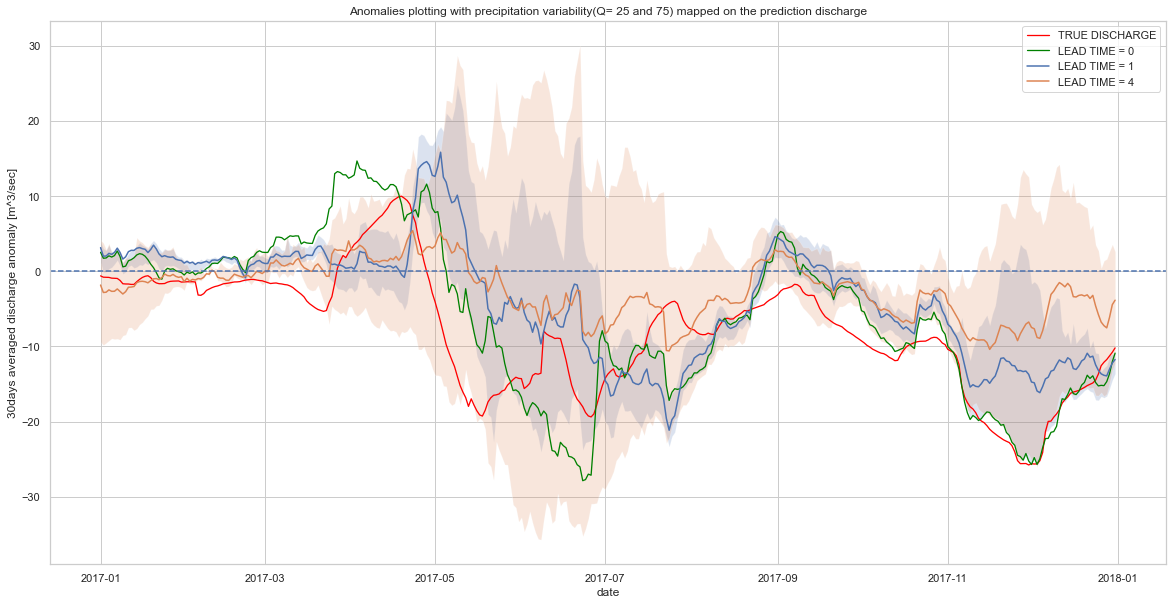

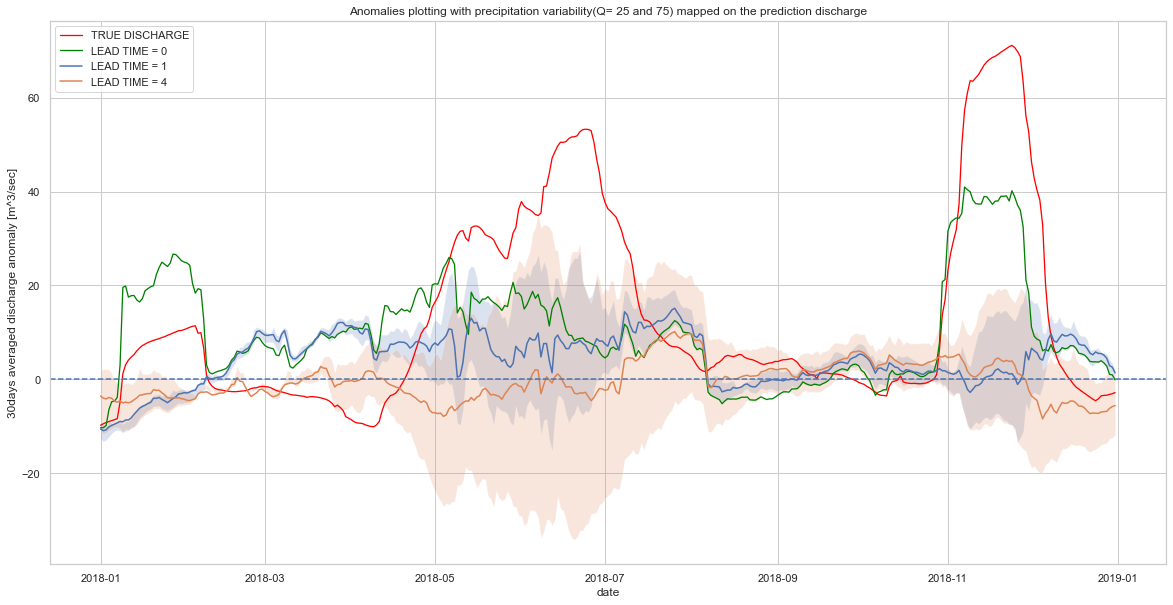

In [34]:
a3=compute_anomalies(climatologies3, predictions3)

a3['split']=predictions3.split
plot_anomalies(a3)

# D) SVR 
## WITH SPATIAL AVERAGE AS INPUT

Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Fitting 1 folds for each of 100 candidates, totalling 100 fits

C4=0.5994842503189409
eps4=0.0012915496650148827


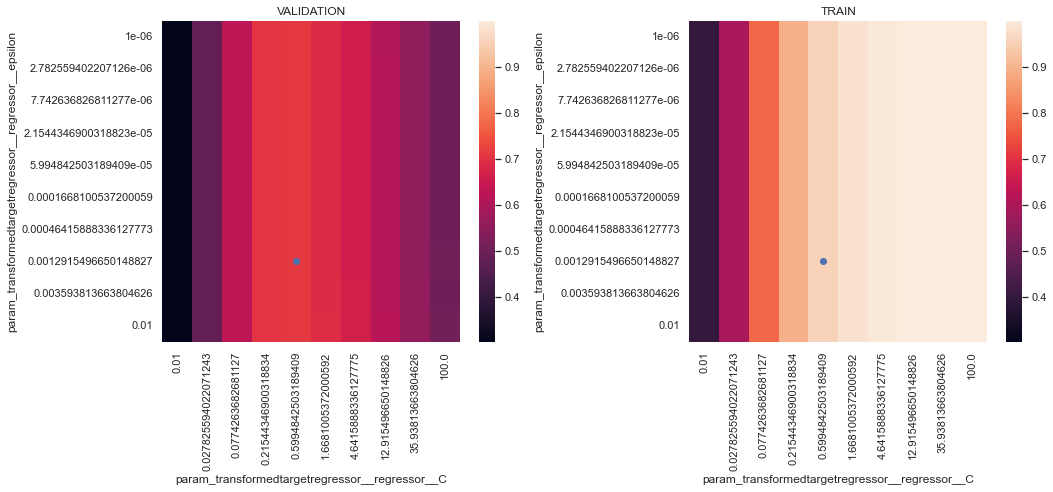

In [35]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range, t_range,n_splits,test_size)
print(f'C4={C4}')
print(f'eps4={eps4}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [36]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat, C4, eps4, 12, n_splits, test_size, radius_for_ensemble)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

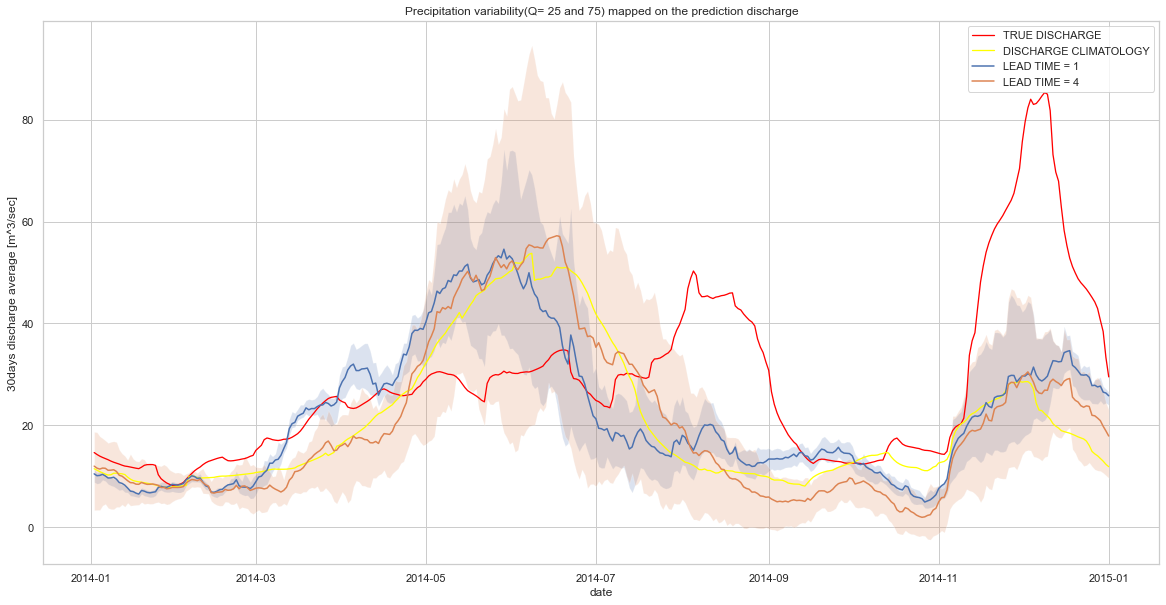

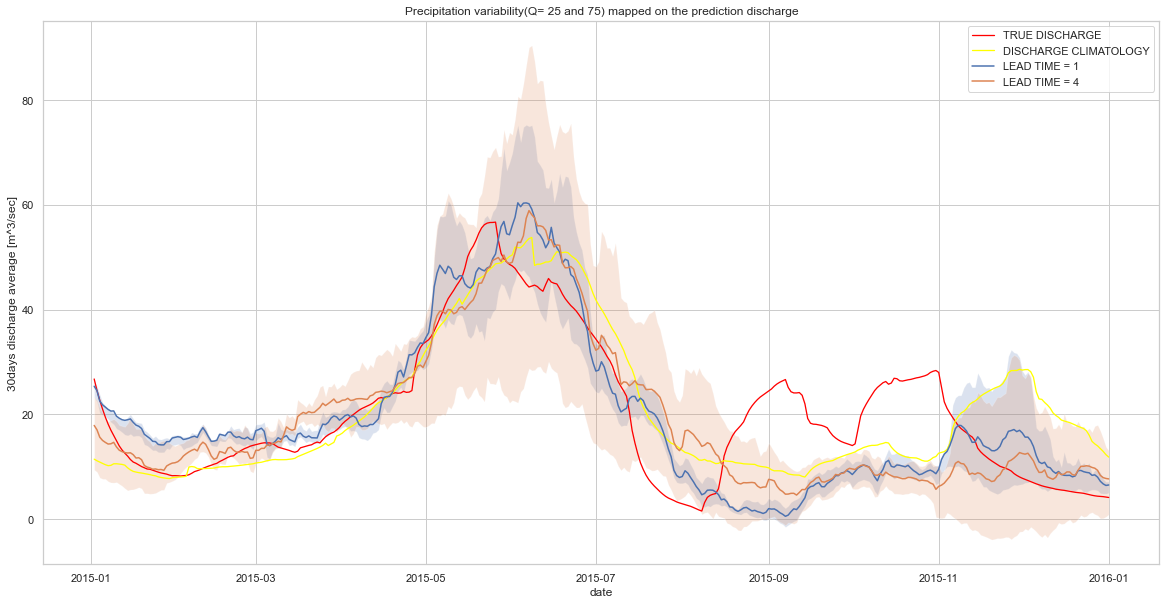

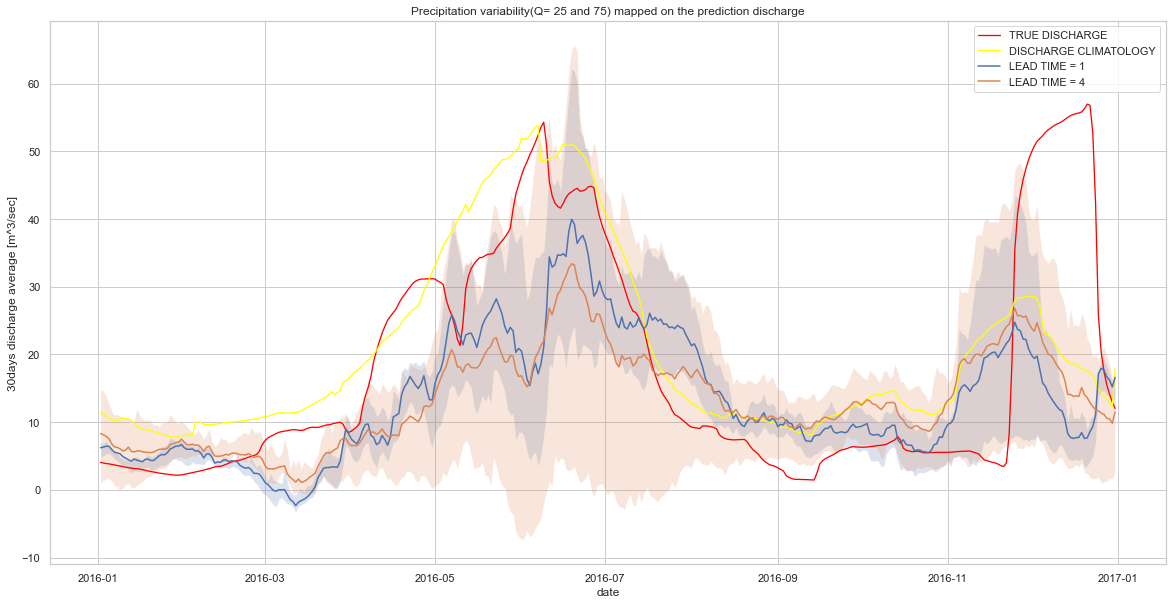

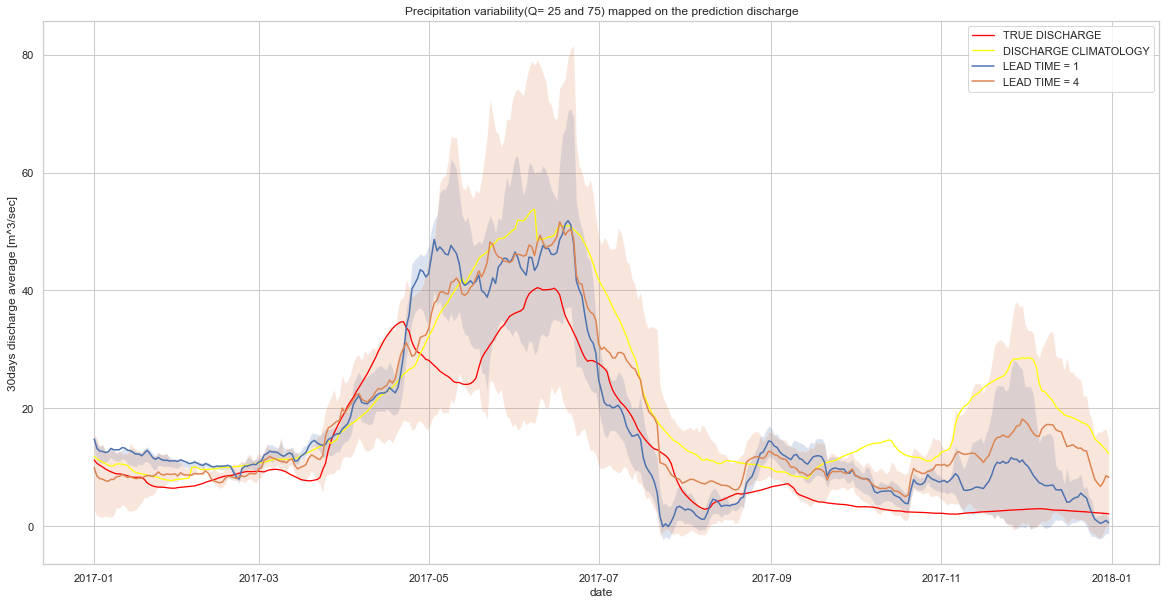

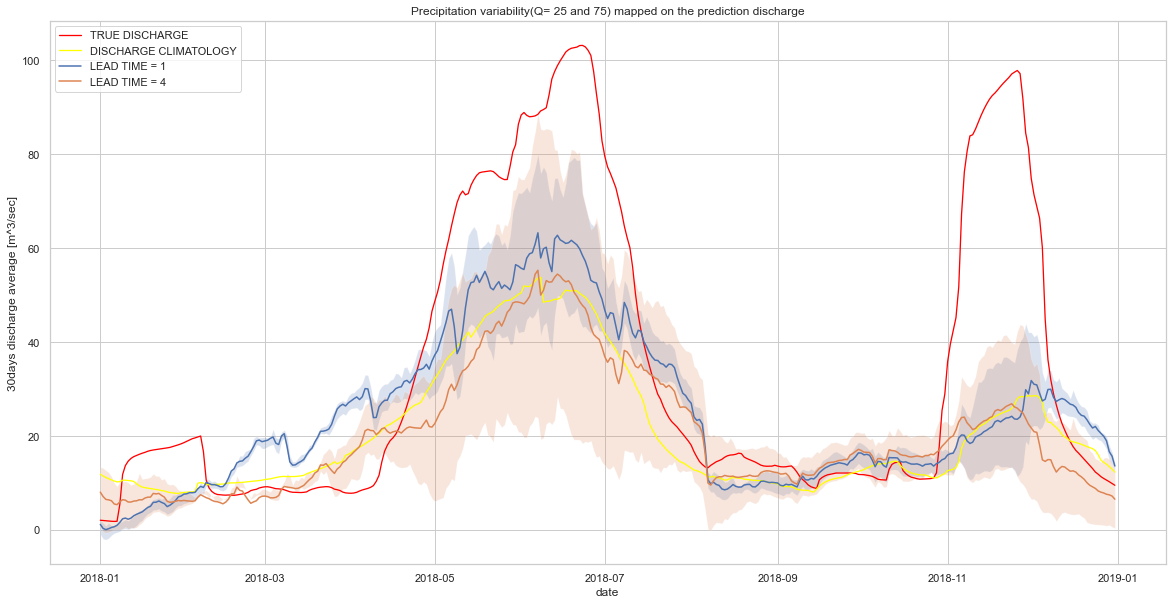

In [37]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4)

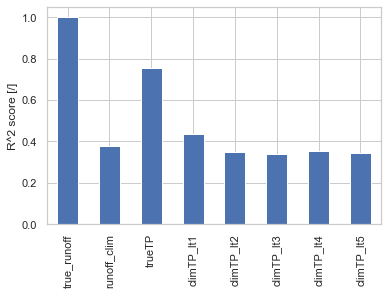

In [38]:
r2_TPE = evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [39]:
predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat, C4, eps4, 12, n_splits)

In [40]:
climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


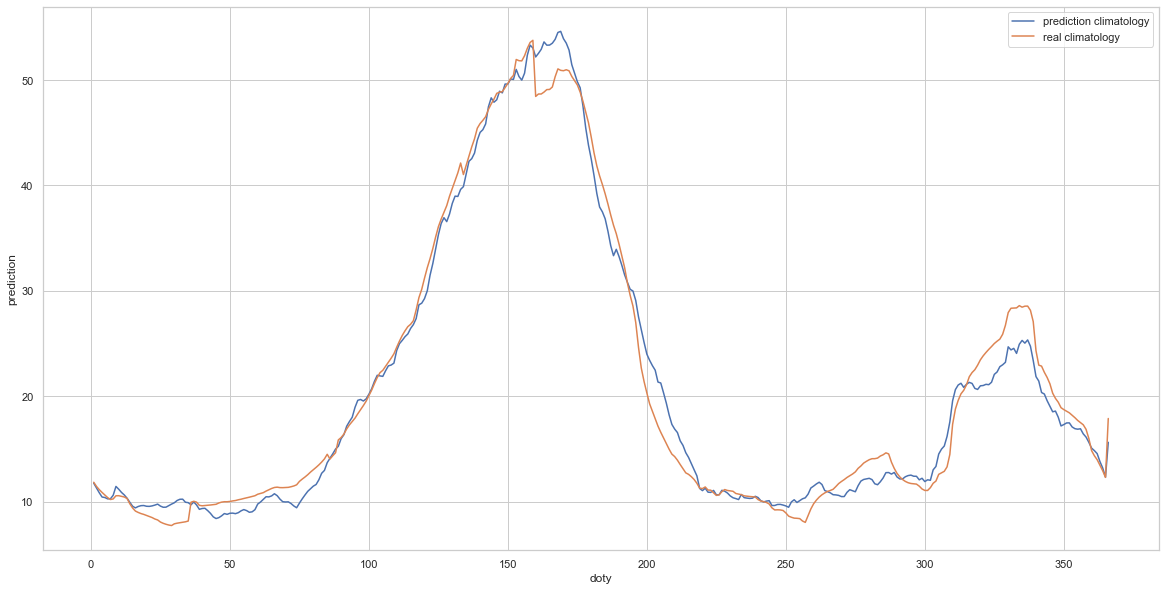

In [41]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

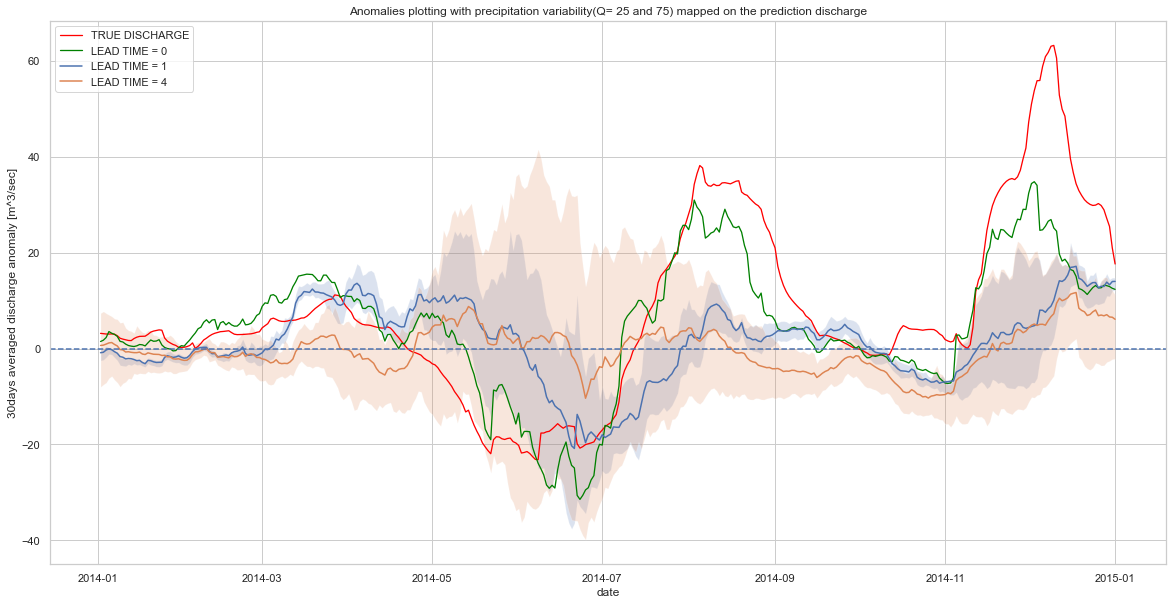

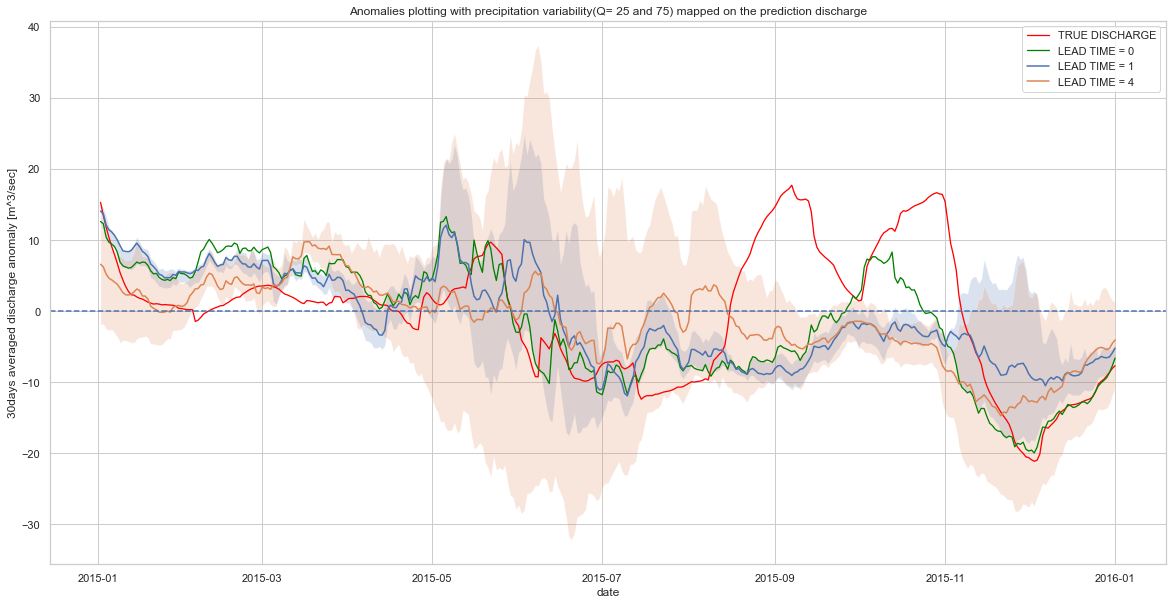

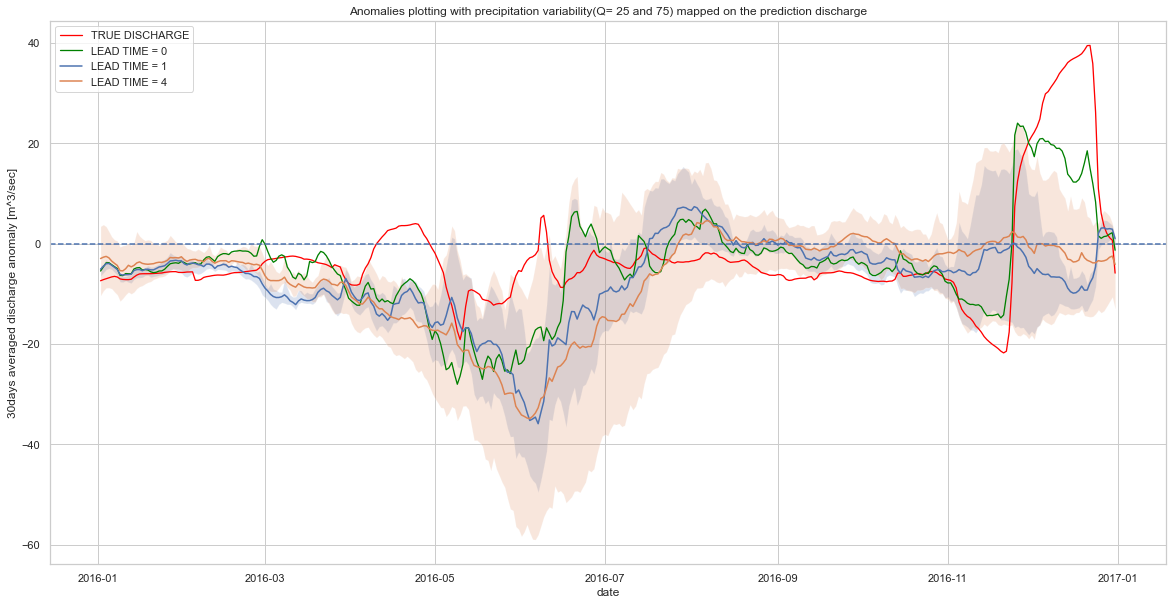

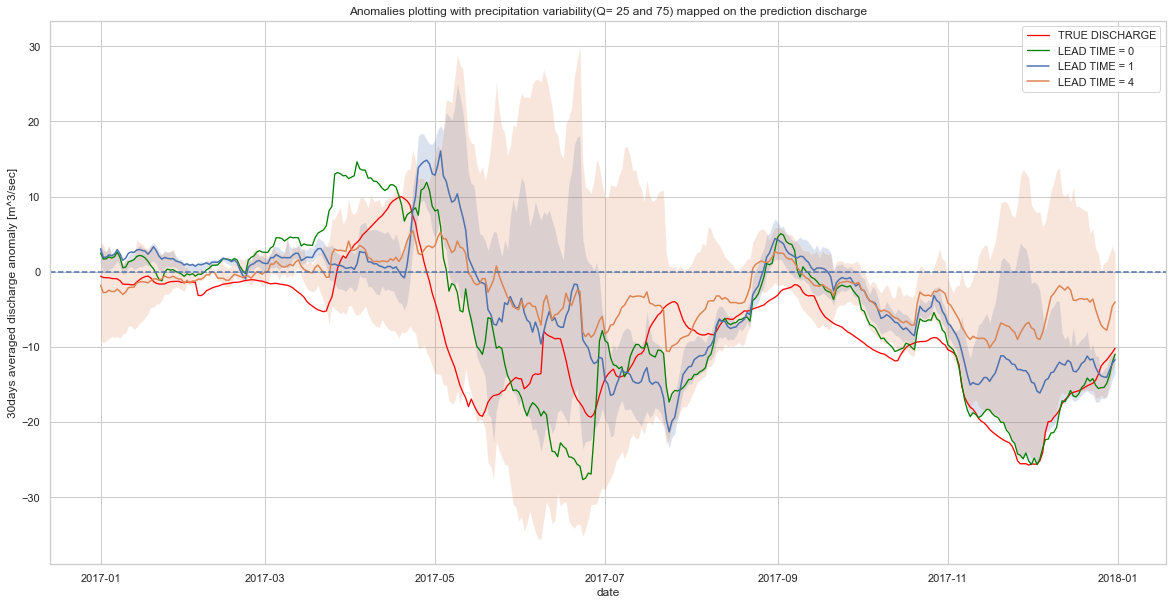

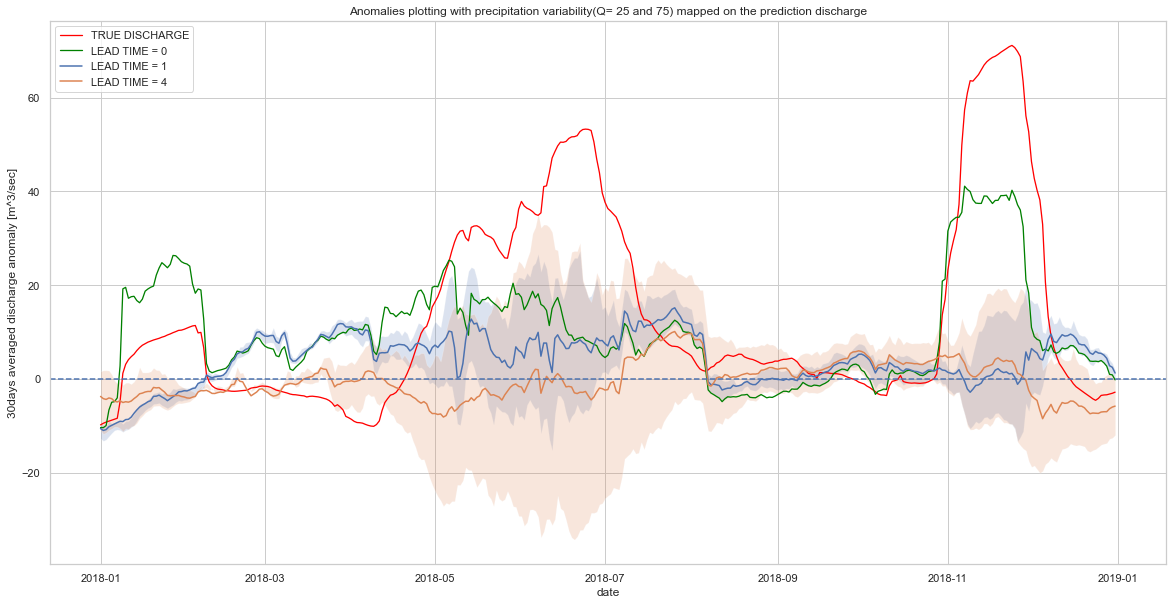

In [44]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split
plot_anomalies(a4)

# COMPARE RESULTS

In [55]:
results = pd.concat([r2_PCA180,r2_PCA36,r2_TPE,r2_STATS,],axis=1)
results.columns=['A) PCA(180)','B) PCA(180)','C) TPE_STATS','D) TPE_AVG']

Text(0, 0.5, 'r^2 [/]')

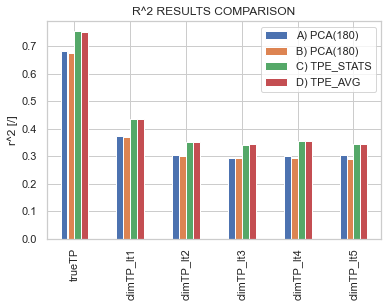

In [61]:
results.iloc[2:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')